In [1]:
# import library
!pip install --upgrade -q transformers datasets evaluate accelerate optuna scikit-learn
import pandas as pd
import numpy as np
import os
import torch
import gc
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, matthews_corrcoef, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, set_seed
from datasets import Dataset

set_seed(42)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 78.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.3/506.3 kB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.9/374.9 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 100.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.3/564.3 kB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 86.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.

2025-10-15 14:45:41.944764: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760539542.116580      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760539542.165491      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# 1: LOAD DATA PREPROCESS
try:
    data_path = "/kaggle/input/sarcasm-preprocessed-4-versions/processed_data_sarcasm"
    df_train = pd.read_parquet(os.path.join(data_path, "train_processed_all_versions.parquet"))
    df_val = pd.read_parquet(os.path.join(data_path, "val_processed_all_versions.parquet"))
    df_test = pd.read_parquet(os.path.join(data_path, "test_processed_all_versions.parquet"))
    print(f"Jumlah data train: {len(df_train)}, val: {len(df_val)}, test: {len(df_test)}")
except Exception as e:
    print(f" Gagal memuat data. Error: {e}")

df_train.head()

Jumlah data train: 9881, val: 1411, test: 2824


,label,text_sw_norm,text_sw_nonorm,text_nosw_norm,text_nosw_nonorm
0,0,bilang chinese playing victim gasadar playing ...,bilang chinese playing victim gasadar playing ...,kamu bilang chinese playing victim tapi kamu g...,lo bilang chinese playing victim tapi lo gasad...
1,0,kadangkadang sampe mikir kayaknya buku mending...,kadangkadang sampe mikir kayaknya buku mending...,kadangkadang sampe aku mikir kayaknya buku beg...,kadangkadang sampe aku mikir kayaknya buku gin...
2,0,bukanya berduka mlh konspirasi,bukanya berduka mlh konspirasi,bukanya berduka mlh buat konspirasi sendiri,bukanya berduka mlh buat konspirasi sendiri
3,0,"atta halilintar pamer youtube dasar pamer, kay...","atta halilintar pamer youtube dasar pamer, kay...","atta halilintar pamer di youtube dasar pamer, ...","atta halilintar pamer di youtube dasar pamer, ..."
4,0,lokasinya kalimantan,lokasinya kalimantan,pasti lokasinya di kalimantan,pasti lokasinya di kalimantan


In [3]:
from huggingface_hub import login
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
hf_token = user_secrets.get_secret("HF_TOKEN")

login(token=hf_token)

In [4]:
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    mcc = matthews_corrcoef(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'mcc': mcc
    }

In [5]:
from torch import nn
from transformers import AutoTokenizer, AutoModel, TrainingArguments, Trainer, set_seed


class TransformerWithFrozenLayers(nn.Module):
    def __init__(self, model_name, num_labels=2, dropout_p=0.2):
        super().__init__()
        # AutoModel
        self.encoder = AutoModel.from_pretrained(model_name)

        #  membekukan layer 1-7 
        frozen_layers = 0
        for name, param in self.encoder.named_parameters():
            if any(f"layer.{i}." in name for i in range(0, 7)):
                param.requires_grad = False
                frozen_layers += 1

        print(f"  - Model: {model_name}")
        print(f"  - Total parameter yang dibekukan: {frozen_layers}")

        self.dropout = nn.Dropout(dropout_p)
        self.classifier = nn.Linear(self.encoder.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)

        pooled_output = outputs.last_hidden_state[:, 0]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.classifier.out_features), labels.view(-1))
            
        return {"loss": loss, "logits": logits}

In [6]:
experiments = {
    "indobert_freeze_7": {
        "model_name": "indobenchmark/indobert-base-p1",
        "column_name": "text_nosw_norm"  
    },
    "indobertweet_freeze_7": {
        "model_name": "indolem/indobertweet-base-uncased", 
        "column_name": "text_nosw_nonorm" 
    }
}

for experiment_name, config in experiments.items():
    
    model_name = config['model_name']
    best_preprocessing_column = config['column_name']
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    train_dataset = Dataset.from_pandas(df_train[['label', best_preprocessing_column]]).rename_column("label", "labels")
    val_dataset = Dataset.from_pandas(df_val[['label', best_preprocessing_column]]).rename_column("label", "labels")
    test_dataset = Dataset.from_pandas(df_test[['label', best_preprocessing_column]]).rename_column("label", "labels")

    def tokenize_function(examples):
        return tokenizer(examples[best_preprocessing_column], padding="max_length", truncation=True, max_length=128)
    
    tokenized_train = train_dataset.map(tokenize_function, batched=True)
    tokenized_val = val_dataset.map(tokenize_function, batched=True)
    tokenized_test = test_dataset.map(tokenize_function, batched=True)
    
    model = TransformerWithFrozenLayers(model_name)
    
    BATCH_SIZE = 16

    training_args = TrainingArguments(
        output_dir=f"./{experiment_name}",
        num_train_epochs=3,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        learning_rate=2e-5,
        weight_decay=0.01,
        eval_strategy="epoch",
        logging_steps=50,
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        fp16=True, 
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    trainer.train()

    print(f"Evaluasi {experiment_name} pada TEST SET...")
    test_predictions = trainer.predict(tokenized_test)
    test_preds_labels = np.argmax(test_predictions.predictions, axis=1)

    print("\nLaporan Klasifikasi Final di Test Set:")
    print(classification_report(tokenized_test["labels"], test_preds_labels, target_names=["Non-Sarkastik", "Sarkastik"]))
    final_mcc = matthews_corrcoef(tokenized_test["labels"], test_preds_labels)
    print(f"Matthews Correlation Coefficient (MCC) Final: {final_mcc:.4f}")
    
    del model, trainer, tokenizer
    torch.cuda.empty_cache()
    gc.collect()



tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/9881 [00:00<?, ? examples/s]

Map:   0%|          | 0/1411 [00:00<?, ? examples/s]

Map:   0%|          | 0/2824 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

  - Model: indobenchmark/indobert-base-p1
  - Total parameter yang dibekukan: 112


/tmp/ipykernel_19/2821503043.py:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Mcc
1,0.424800,0.447381,0.793763,0.766781,0.777035,0.793763,0.370607
2,0.363200,0.428224,0.800850,0.794717,0.791688,0.800850,0.441875
3,0.297300,0.441495,0.796598,0.786320,0.783488,0.796598,0.416074


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Evaluasi indobert_freeze_7 pada TEST SET...


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



Laporan Klasifikasi Final di Test Set:
               precision    recall  f1-score   support

Non-Sarkastik       0.86      0.89      0.87      2118
    Sarkastik       0.63      0.55      0.59       706

     accuracy                           0.81      2824
    macro avg       0.74      0.72      0.73      2824
 weighted avg       0.80      0.81      0.80      2824

Matthews Correlation Coefficient (MCC) Final: 0.4638


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/9881 [00:00<?, ? examples/s]

Map:   0%|          | 0/1411 [00:00<?, ? examples/s]

Map:   0%|          | 0/2824 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

  - Model: indolem/indobertweet-base-uncased
  - Total parameter yang dibekukan: 112


/tmp/ipykernel_19/2821503043.py:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Mcc
1,0.419400,0.419412,0.801559,0.797665,0.795121,0.801559,0.452655
2,0.376400,0.418473,0.795889,0.795696,0.795506,0.795889,0.454936
3,0.330300,0.421712,0.806520,0.798844,0.796164,0.806520,0.451951


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Evaluasi indobertweet_freeze_7 pada TEST SET...


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



Laporan Klasifikasi Final di Test Set:
               precision    recall  f1-score   support

Non-Sarkastik       0.84      0.91      0.87      2118
    Sarkastik       0.63      0.48      0.55       706

     accuracy                           0.80      2824
    macro avg       0.73      0.69      0.71      2824
 weighted avg       0.79      0.80      0.79      2824

Matthews Correlation Coefficient (MCC) Final: 0.4263


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Map:   0%|          | 0/2824 [00:00<?, ? examples/s]

  - Model: indobenchmark/indobert-base-p1
  - Total parameter yang dibekukan: 112
Melakukan prediksi ulang pada test set


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


tes

Laporan Klasifikasi di Test Set:
               precision    recall  f1-score   support

Non-Sarkastik       0.85      0.91      0.88      2118
    Sarkastik       0.65      0.53      0.58       706

     accuracy                           0.81      2824
    macro avg       0.75      0.72      0.73      2824
 weighted avg       0.80      0.81      0.81      2824

Matthews Correlation Coefficient (MCC): 0.4692

Visualisasi Confusion Matrix untuk 'indobert_freeze_7':


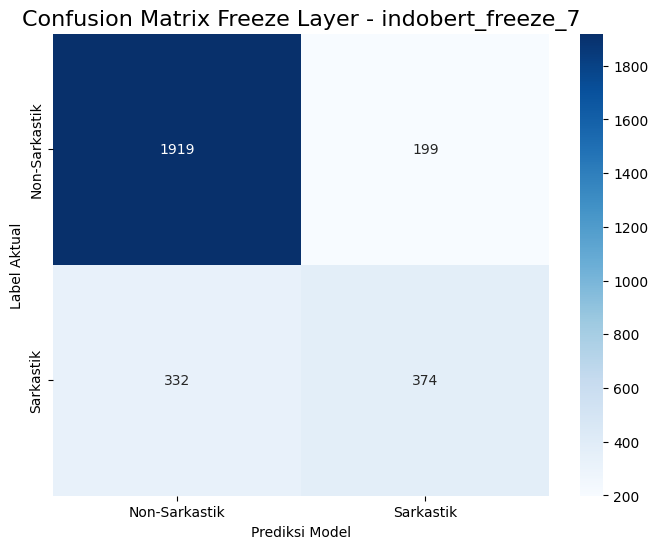

Map:   0%|          | 0/2824 [00:00<?, ? examples/s]

  - Model: indolem/indobertweet-base-uncased
  - Total parameter yang dibekukan: 112
Melakukan prediksi ulang pada test set


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


tes

Laporan Klasifikasi di Test Set:
               precision    recall  f1-score   support

Non-Sarkastik       0.84      0.91      0.87      2118
    Sarkastik       0.63      0.48      0.55       706

     accuracy                           0.80      2824
    macro avg       0.73      0.69      0.71      2824
 weighted avg       0.79      0.80      0.79      2824

Matthews Correlation Coefficient (MCC): 0.4263

Visualisasi Confusion Matrix untuk 'indobertweet_freeze_7':


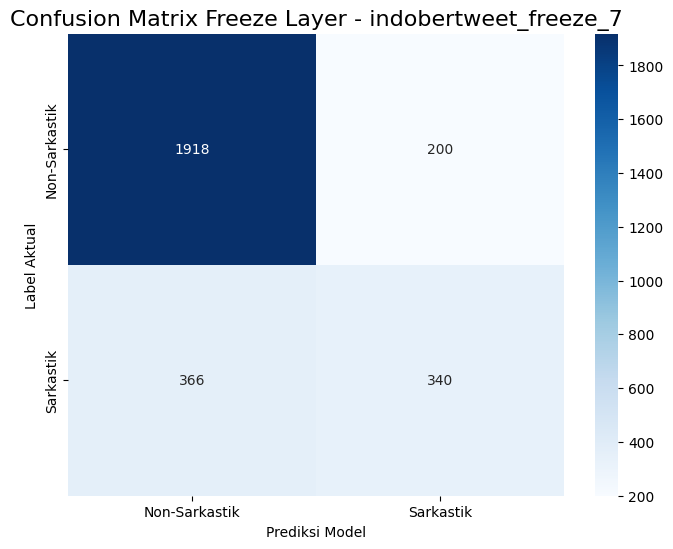

In [7]:
from safetensors.torch import load_file
!pip install -q transformers datasets evaluate accelerate optuna scikit-learn


for experiment_name, config in experiments.items():

    results_dir = f'./{experiment_name}'
    best_checkpoint_name = 'checkpoint-927'
    best_model_checkpoint = os.path.join(results_dir, best_checkpoint_name)

    model_name = config['model_name']
    best_preprocessing_column = config['column_name']

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    test_dataset = Dataset.from_pandas(df_test[['label', best_preprocessing_column]]).rename_column("label", "labels")
    def tokenize_function(examples):
        return tokenizer(examples[best_preprocessing_column], padding="max_length", truncation=True, max_length=128)
    tokenized_test = test_dataset.map(tokenize_function, batched=True)

    model = TransformerWithFrozenLayers(model_name)
    state_dict = load_file(os.path.join(best_model_checkpoint, 'model.safetensors'), device="cuda" if torch.cuda.is_available() else "cpu")
    model.load_state_dict(state_dict)
    
    eval_args = TrainingArguments(
        output_dir="./eval_temp_freeze", 
        dataloader_num_workers=0,   
        report_to="none"
    )
    trainer_for_eval = Trainer(
        model=model,
        args=eval_args 
    )
    print("Melakukan prediksi ulang pada test set")
    test_predictions = trainer_for_eval.predict(tokenized_test)
    print("tes")
    test_preds_labels = np.argmax(test_predictions.predictions, axis=1)

    print("\nLaporan Klasifikasi di Test Set:")
    print(classification_report(tokenized_test["labels"], test_preds_labels, target_names=["Non-Sarkastik", "Sarkastik"]))
    final_mcc = matthews_corrcoef(tokenized_test["labels"], test_preds_labels)
    print(f"Matthews Correlation Coefficient (MCC): {final_mcc:.4f}\n")

    print(f"Visualisasi Confusion Matrix untuk '{experiment_name}':")
    cm = confusion_matrix(tokenized_test["labels"], test_preds_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-Sarkastik", "Sarkastik"], yticklabels=["Non-Sarkastik", "Sarkastik"])
    plt.title(f'Confusion Matrix Freeze Layer - {experiment_name}', fontsize=16)
    plt.xlabel('Prediksi Model')
    plt.ylabel('Label Aktual')
    plt.show()
    
    del model, trainer_for_eval, tokenizer
    torch.cuda.empty_cache()
    gc.collect()
